In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Activating Sink Modules 

Inside Config: 
    
    REQUIRES Particles/ParticlesMain/active/Sink

In ``flash.par`` specify when ``part_hdf5`` files are recorded, simmilar to the settings for checkpoints and plotfiles: 

    particleFileIntervalTime = 1.e10
    particleFileIntervalStep = 0
    particleFileNumber = 0 

Note that you can not turn off sink particles by simply setting ``useParticle`` and ``useSinkParticles`` as ``.false.``. You need to remove the Sink modules inside Config, redo the setup, and compile to turn off the Sink functions.

# Computing Sink Parameters 

The sink particle module requires 3 parameters: 
    
1) ``sink_density_thresh``: above this density value, a sink particle may be formed*  
2) ``sink_accretion_radius`` :  for values r<$r_{acc}$, the gas will accrete onto the sink particle. 
3) ``sink_softening_radius`` : should be set as value equal to accretion radius.  

*: this doesn't garuntee that the sink will be formed, there are additional criterions such as ensuring that the flow is converging, cell is at max level of refinement ..etc that might cause sink to not be formed.

Its is important to set these values correctly since sink particles effectively  "smoothes out" the cells that its located at, we don't have enought resolution to see what happens within the sink particle. Intuitvely, if we set $\rho_{thres}$ to be too large, any density that exceeds this threshold could have its density "cut off" or a sink may form prematurely so the we never get to capture the detailed structure near the center. As shown in the figure below, the green,low-density region shows how if we set the accretion radius too large then the details at the center gets smudged out, and it would be hard to form a disk since the simulation ends prematurely. (Left: earlier timestep ,Right: later timestep)


![test](https://github.com/dorisjlee/remote/blob/master/astroSim-tutorial-img/badsink.png?raw=True)


Jean's length($\lambda_J$) is the length scale associated with the gravitational collapse of a thermally-supported dense core.
$$\lambda_J = \sqrt{\frac{\pi c_s^2}{G\rho}} = 2r_{acc}$$
This critical length scale also defines our density threshold: 
$$\rho_{thres} = \frac{\pi c_s^2}{G\lambda_J^2}= \frac{\pi c_s^2}{4Gr_{acc}^2} $$
By the Truelove criterion, the Jean's length must be covered by at least 4 grid cells ($\lambda_J \approx 2\Delta x$):
$$\rho_{thres} = \frac{\pi c_s^2}{16G\Delta x^2}$$

In [13]:
def compute_sink_param(rho = 1.0e-16,lev_max=9):
    # Simple script for calculating sink parameters 
    G = 6.67e-8
    c_s  = 28730.5 #cm/s (based on T = 10K) 
    jeans_length = sqrt(pi*c_s**2/(G*rho))
    boxlen =1e19
    cell_size = boxlen / 8.0 / 2**(lev_max)

    r_acc = 2.5*cell_size
    rho_threshold=  pi*c_s**2/(16.0*G*cell_size**2)

    print "sink_density_thresh = ", rho_threshold
    print "sink_accretion_radius = ", r_acc
    print "sink_softening_radius = ", r_acc

So for a simulation with ``lrefine_min=5;lrefine_max=7``, the appropriate sink parameters in ``flash.par`` are: 

In [7]:
compute_sink_param(lev_max=7)

sink_density_thresh =  2.54794669312e-17
sink_accretion_radius =  2.44140625e+16
sink_softening_radius =  2.44140625e+16


Previously, we have been using density-based refinement criteria (``refine_var_1="dens"``), which looks at the gradient of the density across different cells to figure out whether more or less refinement is needed. To ensure that the Truelove criterion is satisfied, we should turn off the density-based refinement and use the Jean's refinement instead:   

        refineOnJeansLength=.true.
        jeans_ncells_ref = 32.0
        jeans_ncells_deref = 64.0


# Running the Example

Code example up to now is in ``examples/SinkSphere/``.   
    
    ./setup SinkSphere -3d +usm --maxblock=500 -auto ; cd object/;make -j8;cd ..;
    

In [ ]:
from scripts.plotSim import *

Number of sink particles:  0



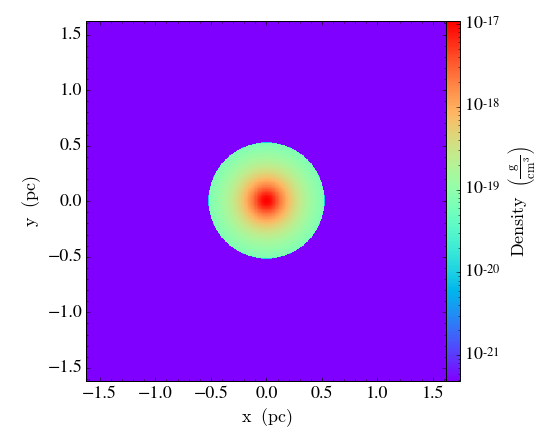

In [87]:
plot_dens(0,particle=True)

You can use yt's ``annotate_particle`` to plot the sink, as the little black dot in the center shown below: 

Number of sink particles:  1



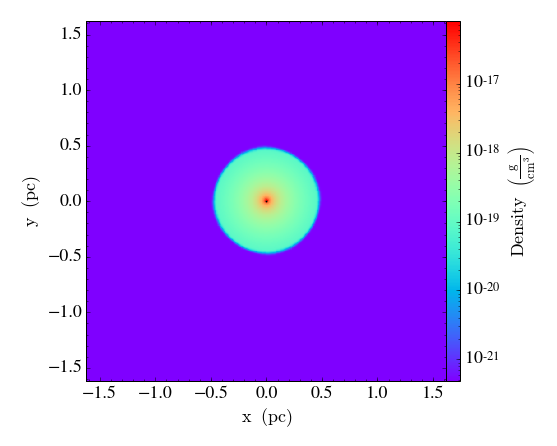

In [89]:
plot_dens(35,particle=True)

# Analyzing Sink Particle data 

The sink particle information is stored inside both the ``part_hdf5`` and ``sinks_evol.dat``.

FLASH provides a python script for cleaning up the sink outputs, so that all the redundant information about a sink particle in ``sink_evol.dat`` are removed in ``sinks_evol.dat_cleaned``.

~~~bash
cd object/
cp ../source/Simulation/SimulationMain/unitTest/SinkMomTest/utils/clean_sinks_evol.py .
python clean_sinks_evol.py
~~~

 ``sinks_evol.dat_cleaned`` is a text file that can be easily parsed to examine the positions of the sink, when its created (``ptime``), its mass accretion rate (``mdot``) and other kinematic information. This is the snippet of code inside ``plotSim.py`` that drew in the sink particle shown above.

~~~python
if particle :
        os.system("cp ../source/Simulation/SimulationMain/unitTest/SinkMomTest/utils/clean_sinks_evol.py .")
        os.system("python clean_sinks_evol.py")
        data =np.loadtxt("sinks_evol.dat_cleaned",skiprows=1)
        pcl_indx_at_t = np.where(np.isclose(int(ds.current_time.in_cgs()),data[:,1]))[0]
        print "Number of sink particles: " , len(pcl_indx_at_t)
        pcl_pos_at_t = data[pcl_indx_at_t,2:5]
        for pos in pcl_pos_at_t:
            slc.annotate_marker(pos, coord_system='data',marker='.',plot_args={'color':'black','s':3})
~~~

# Reference:   
- ``19.4.2 Using the Sink Particle Unit`` of the [FLASH user guide](http://flash.uchicago.edu/site/flashcode/user_support/flash4_ug_4p3/).
- Federrath, C., Banerjee, R., Clark, P. C., & Klessen, R. S. (2010). *Modeling Collapse and Accretion in Turbulent Gas Clouds: Implementation and Comparison of Sink Particles in AMR and SPH.* The Astrophysical Journal, 713(1), 269–290. doi:10.1088/0004-637X/713/1/269